In [25]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
try:
    os.mkdir('figures')
except FileExistsError:
    pass

import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
from ccmf import CCMF, CircuitEditor, UniformModel, load_fake_dm9

np.random.seed(69)

In [2]:
notebook_name = 'linear_no_noise'

# Load circuit

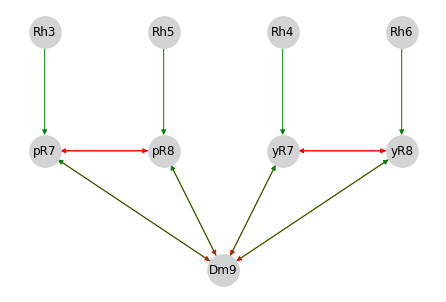

In [3]:
circuit = pickle.load(open('circuits/Dm9.circuit', 'rb'))
circuit.show()

# Load data

In [4]:
W, M, U, X = load_fake_dm9()
X.columns = pd.Index(X.columns.values.astype(int), name=X.columns.name)
X

stimulus,300,327,355,383,411,438,466,494,522,550
cell,,,,,,,,,,
Rh3,0.606531,0.905955,0.993846,0.800737,0.473827,0.205924,0.065729,0.015408,0.002653,0.000335
Rh4,0.135335,0.352322,0.673638,0.945959,0.975611,0.738991,0.411112,0.167973,0.050406,0.011109
Rh5,0.011109,0.050406,0.167973,0.411112,0.738991,0.975611,0.945959,0.673638,0.352322,0.135335
Rh6,0.000335,0.002653,0.015408,0.065729,0.205924,0.473827,0.800737,0.993846,0.905955,0.606531
pR7,0.792459,1.161199,1.194870,0.762329,0.079556,-0.473936,-0.670218,-0.556945,-0.332050,-0.150686
yR7,0.171381,0.454857,0.869636,1.186215,1.103980,0.571343,-0.112891,-0.566997,-0.637469,-0.450452
pR8,-0.398385,-0.549900,-0.456876,-0.016921,0.609885,1.065438,1.090244,0.759515,0.367288,0.119314
yR8,-0.098619,-0.244481,-0.446824,-0.574247,-0.435394,0.041014,0.666359,1.084749,1.073630,0.740392
Dm9,-0.026529,-0.039411,-0.054828,-0.093737,-0.178657,-0.294283,-0.381648,-0.385191,-0.302119,-0.182729


# Add noise

In [37]:
Xset = pd.concat([X + np.random.normal(0, .25, X.shape) for _ in range(100)])

In [5]:
Xmean = Xset.groupby('cell').mean().loc[X.index]

# One sample from the data set

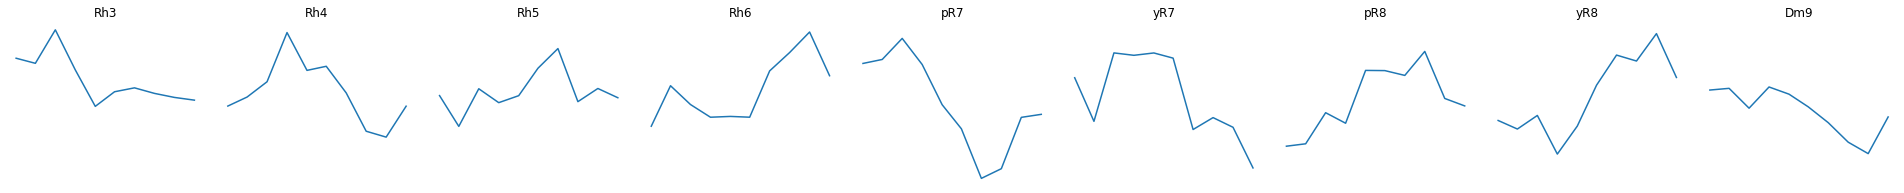

In [6]:
g = sns.FacetGrid(Xset.iloc[:len(X)].stack().to_frame().reset_index(), col='cell')
g.map_dataframe(sns.lineplot, x='stimulus', y=0)
for i, ax in enumerate(g.axes.ravel()):
    ax.axis('off')
    ax.set_title(X.index[i])

# Data mean and SD

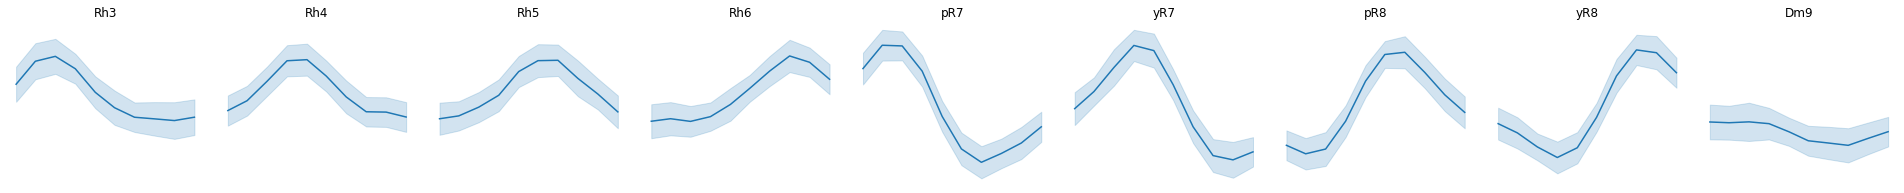

In [7]:
g = sns.FacetGrid(Xset.stack().to_frame().reset_index(), col='cell')
g.map_dataframe(sns.lineplot, x='stimulus', y=0, ci='sd')
for i, ax in enumerate(g.axes.ravel()):
    ax.axis('off')
    ax.set_title(X.index[i])

# Fitting (MAP estimation)

In [8]:
ccmf = CCMF(UniformModel(circuit), sigma_u=1, sigma_x=1, max_iter=2000)
ccmf.fit(Xset)

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 83.14it/s]


CCMF(guide=None, kernel=None, loss=None, model=None, optimizer=None)

Text(0, 0.5, 'Loss')

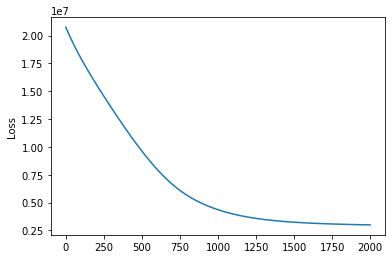

In [9]:
plt.figure()
plt.plot(ccmf.loss_curve)
plt.ylabel('Loss')

# Run MCMC

In [10]:
ccmf.run_mcmc(Xset)

Sample: 100%|██████████████████████████████████████| 100/100 [10:31,  6.32s/it, step size=4.88e-04, acc. prob=0.585]


CCMF(guide=None, kernel=None, loss=None, model=None, optimizer=None)

In [13]:
EX = lambda W, M, U: torch.cat([U, UniformModel.EV(W, M, U)])
data = dict(W=W, M=M, U=U, X=Xmean)
for i in ['U', 'X']:
    data[i].columns = pd.Index(data['X'].columns.values.astype(int), name=data['X'].columns.name)
map_ = ccmf.map_estimates.copy()
mean = ccmf.sample_mean.copy()
mean['X'] = EX(mean['W'], mean['M'], mean['U'])
map_['X'] = EX(map_['W'], map_['M'], map_['U'])

# Comparing data, MAP, and sample mean
## Feedforward weights

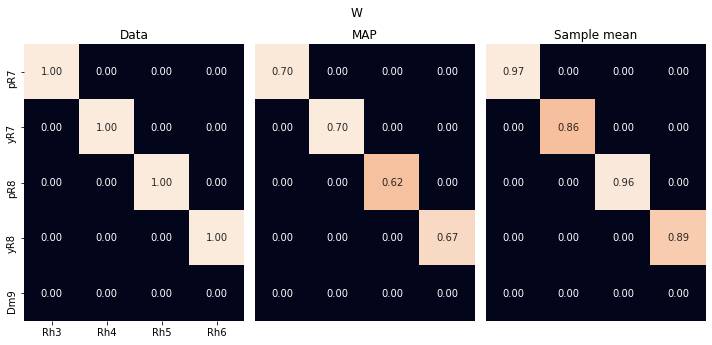

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'W'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Recurrent weights

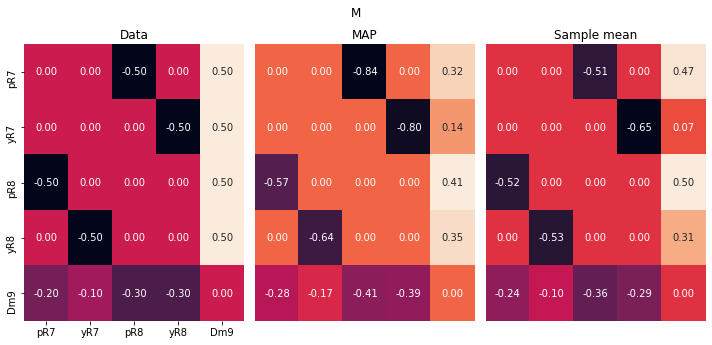

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'M'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Latent inputs

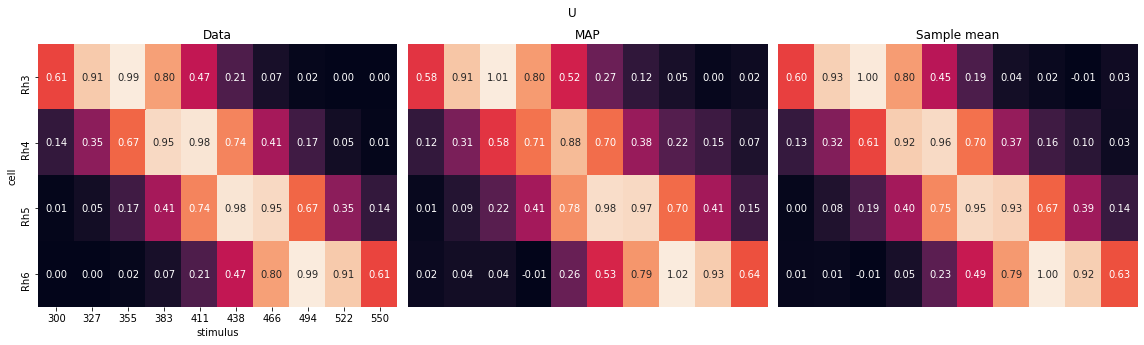

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'U'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Responses

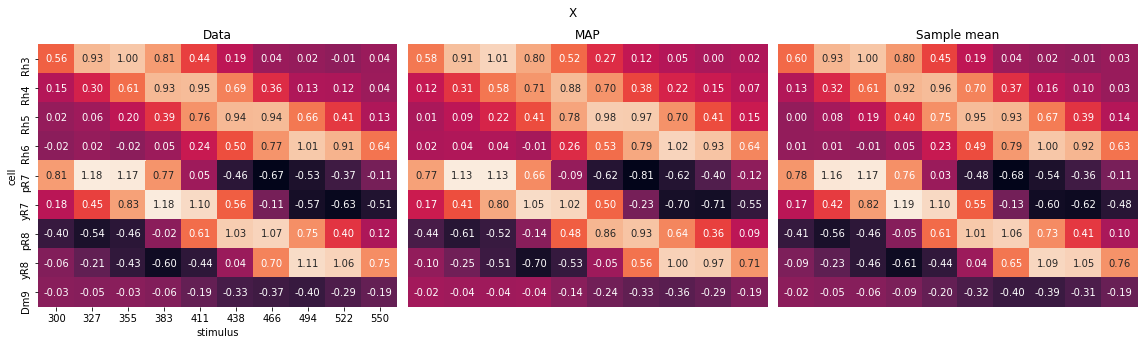

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'X'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Graphical posterior predictive checking

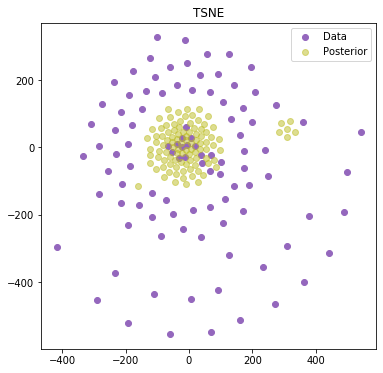

In [24]:
Xflat = np.stack([Xset.iloc[i*9:(i+1)*9].values.ravel() for i in range(len(Xset) // 9)])
samples = ccmf.get_samples()
post_samples = np.array(torch.stack([EX(Wi, Mi, Ui).flatten() for Wi, Mi, Ui in zip(samples['W'], samples['M'], samples['U'])]))
concat = np.concatenate([Xflat, post_samples])
embedding = TSNE(n_components=2, random_state=69)
y = embedding.fit_transform(concat)
labels = np.array([0] * len(Xflat) + [1] * len(post_samples))

plt.figure(figsize=(6, 6))
plt.scatter(*y[labels==0].T, label='Data', c='C4')
plt.scatter(*y[labels==1].T, label='Posterior', c='C8', alpha=.5)
plt.legend()
plt.title('TSNE')
plt.savefig(f'figures/{notebook_name}_tsne.svg', format='svg')